In [46]:
from __future__ import print_function
from urllib.request import urlretrieve
from torch.utils.data import Dataset
from torch import optim

import os
import pickle as pkl
import numpy as np
import torch

import torch
import torch.utils.data

from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
import torch.nn as nn

import matplotlib.pyplot as plt
from IPython.display import clear_output

import imageio
from google.colab import drive
drive.mount('/content/gdrive')

In [47]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
batch_size = 64
log_interval = 100
epochs = 10
root = os.getcwd()
print(f"Current working directory: {root}")

Current working directory: C:\Users\Zuzka\Desktop


In [48]:
def load_mnist_binarized(root):
    datapath = os.path.join(root, 'bin-mnist')
    if not os.path.exists(datapath):
        os.makedirs(datapath)
    dataset = os.path.join(datapath, "mnist.pkl.gz")

    if not os.path.isfile(dataset):

        datafiles = {
            "train": "http://www.cs.toronto.edu/~larocheh/public/"
                     "datasets/binarized_mnist/binarized_mnist_train.amat",
            "valid": "http://www.cs.toronto.edu/~larocheh/public/datasets/"
                     "binarized_mnist/binarized_mnist_valid.amat",
            "test": "http://www.cs.toronto.edu/~larocheh/public/datasets/"
                    "binarized_mnist/binarized_mnist_test.amat"
        }
        datasplits = {}
        for split in datafiles.keys():
            print("Downloading %s data..." % (split))
            datasplits[split] = np.loadtxt(urlretrieve(datafiles[split])[0])

        pkl.dump([datasplits['train'], datasplits['valid'], datasplits['test']], open(dataset, "wb"))

    x_train, x_valid, x_test = pkl.load(open(dataset, "rb"))
    return x_train, x_valid, x_test


class BinMNIST(Dataset):
    """Binary MNIST dataset"""

    def __init__(self, data, device='cpu', transform=None):
        h, w, c = 28, 28, 1
        self.device = device
        self.data = torch.tensor(data, dtype=torch.float).view(-1, c, h, w)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample.to(self.device)


def get_binmnist_datasets(root, device='cpu'):
    x_train, x_valid, x_test = load_mnist_binarized(root)
    x_train = np.append(x_train, x_valid, axis=0)  # https://github.com/casperkaae/LVAE/blob/master/run_models.py (line 401)
    return BinMNIST(x_train, device=device), BinMNIST(x_test, device=device), BinMNIST(x_test, device=device)

In [49]:
# # LOAD BINMNIST DATASET
# x_train, x_valid, x_test = get_binmnist_datasets(root)

# train_loader = torch.utils.data.DataLoader(x_train, batch_size=batch_size, shuffle=True, pin_memory=cuda)
# test_loader  = torch.utils.data.DataLoader(x_test, batch_size=batch_size, shuffle=True, pin_memory=cuda)

In [50]:
# # plot a few MNIST examples
# f, axarr = plt.subplots(4, 16, figsize=(16, 4))

# # Load a batch of images into memory
# images = next(iter(train_loader))

# for i, ax in enumerate(axarr.flat):
#     ax.imshow(images[i].view(28, 28), cmap="binary_r")
#     ax.axis('off')
    
# plt.suptitle('MNIST handwritten digits')
# plt.show()

In [64]:
class Sketch(Dataset):
    """Sketch dataset"""

    def __init__(self, data, labels, device='cpu', transform=None):
        h, w, c = 28, 28, 1
        self.device = device
        self.data = torch.tensor(data, dtype=torch.float).view(-1, c, h, w)
        print(data.shape)
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        
        if self.transform:
            sample = self.transform(sample)
            label = self.transform(label)
        return sample.to(self.device), label


def convert_img2norm(img_list, ypixels, xpixels):
    norm_list = img_list.copy()
    norm_list = norm_list.astype('float32') / 255
    norm_list = np.reshape(norm_list, (len(norm_list), ypixels, xpixels, 1))
    
    return norm_list
    
    
def load_sketches(root):
    data_dir = "gdrive/My Drive/dataset"
    categories = ['cat', 'dog', 'pig', 'toothbrush']

    xpixels = 28
    ypixels = 28

    category_filenames = []
    for cat_name in categories:
        filename = os.path.join(data_dir, "full_numpy_bitmap_" + cat_name + ".npy")
        category_filenames.append(filename)

    n_take_train = 8000  # number of training images from each category
    n_take_test = 1600   # number of test images from each category
    
    # Load images
    n_categories = len(categories)  # number of classes

    # Training images and labels
    x_train = []
    y_train = []
    
    # Test images and labels
    x_test = []
    y_test = []  

    for i_category, category in enumerate(categories):
        data = np.load(category_filenames[i_category])
        n_data = len(data)
        
        print("[%d/%d] Reading category index %d: '%s' (%d images: take %d training, take %d test)" %
              (i_category+1, n_categories, i_category, category, n_data, n_take_train, n_take_test))

        for j, data_j in enumerate(data):
            img = np.array(data_j).reshape((ypixels, xpixels))
            if j < n_take_train:   # append to training set
                x_train.append(img)
                y_train.append(i_category)  
            elif j - n_take_train < n_take_test: # append to test set
                x_test.append(img)
                y_test.append(i_category) 
            else:
                break

    # Convert to numpy
    x_train = np.array(x_train)
    y_train = np.array(y_train) 
    x_test = np.array(x_test)
    y_test = np.array(y_test)  
    
    # Convert greyscale images to have values [0,1] and reshape to (n, ypixels, xpixels, 1)
    x_train = convert_img2norm(x_train, ypixels, xpixels)
    x_test = convert_img2norm(x_test, ypixels, xpixels)
    
    return Sketch(x_train, y_train, device=device), Sketch(x_test, y_test, device=device)

In [65]:
# LOAD QUICKDRAW (SKETCHES) DATASET
x_train, x_test = load_sketches(root)

train_loader = torch.utils.data.DataLoader(x_train, batch_size=batch_size, shuffle=True, pin_memory=cuda)
test_loader  = torch.utils.data.DataLoader(x_test, batch_size=batch_size, shuffle=True, pin_memory=cuda)

[1/4] Reading category index 0: 'cat' (123202 images: take 8000 training, take 1600 test)
[2/4] Reading category index 1: 'dog' (152159 images: take 8000 training, take 1600 test)
[3/4] Reading category index 2: 'pig' (186770 images: take 8000 training, take 1600 test)
[4/4] Reading category index 3: 'toothbrush' (124828 images: take 8000 training, take 1600 test)
(32000, 28, 28, 1)
(6400, 28, 28, 1)


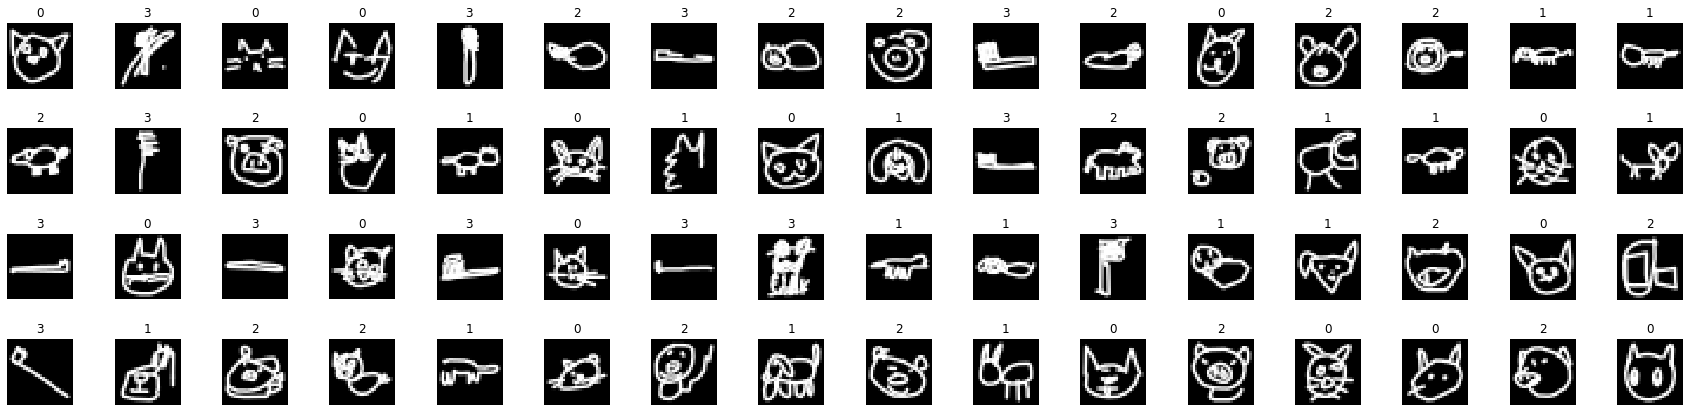

In [66]:
# Plot a few sketch examples
f, axarr = plt.subplots(4, 16, figsize=(24, 6))
f.tight_layout()

# Load a batch of images into memory
images, labels = next(iter(train_loader))

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.title.set_text(labels[i].item())
    ax.axis('off')
    
plt.show()

In [67]:
ngf = 4 #64
ndf = 4 #64
nc = 1
h_dim= 1024


class conv_VAE(nn.Module):
    def __init__(self, nz=32):
        super(conv_VAE, self).__init__()
        
        self.have_cuda = True
        self.nz = nz
        
        self.encoder = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, h_dim, 4, 1, 0, bias=False),
            # nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Sigmoid()
        )
        
        
        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( h_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     nc, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ngf),
            # nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            # nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            # nn.Tanh()
            nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )
        
        self.fc1 = nn.Linear(h_dim, 512)
        self.fc21 = nn.Linear(512, nz)
        self.fc22 = nn.Linear(512, nz)

        self.fc3 = nn.Linear(nz, 512)
        self.fc4 = nn.Linear(512, h_dim)

        self.lrelu = nn.LeakyReLU()
        self.relu = nn.ReLU()
        # self.sigmoid = nn.Sigmoid()
        
    def encode(self, x):
        conv = self.encoder(x);
        # print("encode conv", conv.size())
        h1 = self.fc1(conv.view(-1, h_dim))
        # print("encode h1", h1.size())
        return self.fc21(h1), self.fc22(h1)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        deconv_input = self.fc4(h3)
        # print("deconv_input", deconv_input.size())
        deconv_input = deconv_input.view(-1, h_dim, 1, 1)
        # print("deconv_input", deconv_input.size())
        return self.decoder(deconv_input)

    def reparametrize(self, mu, logvar): 
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        # print("x", x.size())
        mu, logvar = self.encode(x)
        # print("mu, logvar", mu.size(), logvar.size())
        z = self.reparametrize(mu, logvar)
        # print("z", z.size())
        decoded = self.decode(z)
        # print("decoded", decoded.size())
        return decoded, mu, logvar

In [68]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [69]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl = -0.5 * torch.sum(1 + logvar - mu**2 - torch.exp(logvar), dim=1)

    return BCE + KLD, kl.mean()

In [70]:
model = conv_VAE().to(device)
# model = VAE().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_loss_all = []
test_loss_all = []
kl_loss_train = []
kl_loss_test = []
test_loss_all = []

def train(epoch):
    model.train()
    train_loss = 0
    batch_idx = 0
    batch_kl = []
    batch_elbo = []

    for data, _ in train_loader:  # label exists for QUICKDRAW dataset, not MNIST!
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, kld = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        batch_kl.append(kld.item())

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
            
        batch_idx = batch_idx + 1

    kl_loss_train.append(np.mean(batch_kl))

    train_mean = train_loss / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_mean))
    train_loss_all.append(train_mean)


def test(epoch):
    show_img = False
    datapath = os.path.join(root, 'results')
    if not os.path.exists(datapath):
        os.makedirs(datapath)
    model.eval()
    test_loss = 0
    batch_kl = []
    
    with torch.no_grad():
        for data, _ in test_loader:  # label exists for QUICKDRAW dataset, not MNIST!
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss, kld = loss_function(recon_batch, data, mu, logvar)
            test_loss += loss.item()

            batch_kl.append(kld.item())

            # if i == 0:
            #     n = min(data.size(0), 8)
            #     comparison = torch.cat([data[:n],
            #                           recon_batch.view(batch_size, 1, 28, 28)[:n]])
            #     save_image(comparison.cpu(),
            #              'results/reconstruction_' + str(epoch) + '.png', nrow=n)
     
            recon_batch = recon_batch.to("cpu")

            if show_img:
                # Show input digits
                f, axarr = plt.subplots(8, 8, figsize=(8, 8))
                for i, ax in enumerate(axarr.flat):
                    ax.imshow(data[i].view(28, 28), cmap="binary_r")
                    ax.axis('off')
                plt.suptitle('Inputs')
                plt.show()

                # Show reconstructions
                f, axarr = plt.subplots(8, 8, figsize=(8, 8))
                for i, ax in enumerate(axarr.flat):
                    ax.imshow(recon_batch[i].view(28, 28), cmap="binary_r")
                    ax.axis('off')
                plt.suptitle('Reconstructions')
                plt.show()

                # Show latent space samples        
                with torch.no_grad():
                    sample = torch.randn(64, 20).to(device)
                    sample = model.decode(sample).cpu()
                    f, axarr = plt.subplots(8, 8, figsize=(8, 8))
                    for i, ax in enumerate(axarr.flat):
                        ax.imshow(sample[i].view(28, 28), cmap="binary_r")
                        ax.axis('off')
                    plt.suptitle('Latent space')
                    plt.show()
                show_img = False

    kl_loss_test.append(np.mean(batch_kl))

    test_mean = test_loss / len(test_loader.dataset)
    test_loss_all.append(test_mean)
    print('====> Test set loss: {:.4f}'.format(test_mean))

In [71]:
def plot_data(epoch_list, train_loss_all, test_loss_all, kl_loss_train, kl_loss_test):
        # Overall loss (ELBO)
        plt.plot(epoch_list, train_loss_all, color="blue")
        plt.plot(epoch_list, test_loss_all, color="green", linestyle="--")
        plt.legend(['Training', 'Testing'])
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()

        # KL loss
        plt.plot(epoch_list, kl_loss_train, color="blue")
        plt.plot(epoch_list, kl_loss_test, color="green", linestyle="--")
        plt.legend(['Training', 'Testing'])
        plt.xlabel('epochs')
        plt.ylabel('KL loss')
        plt.show()

In [72]:
if __name__ == "__main__":

    epoch_list = []
    for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch)
        epoch_list.append(epoch)
        if epoch == 1:
            continue

        # plot_data(epoch_list, train_loss_all, test_loss_all, kl_loss_train, kl_loss_test)
        print("################################################################")
            
            # save_image(sample.view(64, 1, 28, 28),
            #            'results/sample_' + str(epoch) + '.png')

        #clear_output(wait=True)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Using a target size (torch.Size([64, 784])) that is different to the input size (torch.Size([64, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  This is separate from the ipykernel package so we can avoid doing imports until


Train Epoch: 1 [0/32000 (0%)]	Loss: 594.566284
Train Epoch: 1 [6400/32000 (20%)]	Loss: 337.555939
Train Epoch: 1 [12800/32000 (40%)]	Loss: 285.525848
Train Epoch: 1 [19200/32000 (60%)]	Loss: 272.576294
Train Epoch: 1 [25600/32000 (80%)]	Loss: 253.390305
====> Epoch: 1 Average loss: 299.9369
====> Test set loss: 242.1796
Train Epoch: 2 [0/32000 (0%)]	Loss: 235.515762
Train Epoch: 2 [6400/32000 (20%)]	Loss: 230.801147
Train Epoch: 2 [12800/32000 (40%)]	Loss: 239.494934
Train Epoch: 2 [19200/32000 (60%)]	Loss: 223.909409
Train Epoch: 2 [25600/32000 (80%)]	Loss: 238.711441
====> Epoch: 2 Average loss: 233.2636
====> Test set loss: 225.1718
################################################################
Train Epoch: 3 [0/32000 (0%)]	Loss: 230.233002
Train Epoch: 3 [6400/32000 (20%)]	Loss: 221.135315
Train Epoch: 3 [12800/32000 (40%)]	Loss: 232.509613
Train Epoch: 3 [19200/32000 (60%)]	Loss: 233.493011
Train Epoch: 3 [25600/32000 (80%)]	Loss: 226.342575
====> Epoch: 3 Average loss: 223.7342